In [21]:
import geopandas as gpd
from shapely.geometry import Point, MultiPoint, MultiLineString, LineString
from shapely.ops import split, nearest_points

In [22]:
# load NG raw buses data
ng_buses = gpd.read_file("/home/matin/Downloads/all_raw_substations.geojson")
ng_lines = gpd.read_file("/home/matin/Downloads/all_raw_lines.geojson")

ng_lines['id'] = ng_lines['id'].astype(int)
ng_buses['id'] = ng_buses['id'].astype(int)





In [23]:
us_buses = gpd.read_file("/home/matin/Downloads/all_raw_substations (1).geojson")
us_lines = gpd.read_file("/home/matin/Downloads/all_raw_lines (1).geojson")

us_lines['id'] = us_lines['id'].astype(int)
us_buses['id'] = us_buses['id'].astype(int)

In [24]:
buses = us_buses
lines = us_lines
tol = 1 #meters

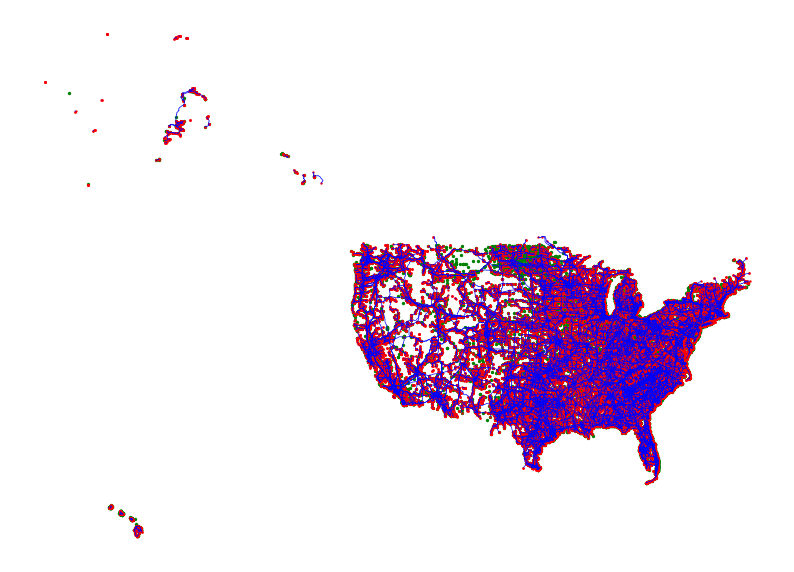

In [25]:

# plot buses and lines on the same map

import matplotlib.pyplot as plt
ax = buses.plot(figsize=(10, 10), color='green', markersize=2)
lines.plot(ax=ax, color='blue', linewidth=0.5)
# plot start and end points of lines
lines_start = lines.copy()
lines_start.geometry = lines_start.geometry.apply(lambda x: Point(x.coords[0]))
lines_start.plot(ax=ax, color='red', markersize=0.5)
lines_end = lines.copy()
lines_end.geometry = lines_end.geometry.apply(lambda x: Point(x.coords[-1]))
lines_end.plot(ax=ax, color='red', markersize=1)
ax.set_axis_off()
plt.show()



In [26]:
# copied over function from build osm network
import pandas as pd
from tqdm import tqdm

def _split_linestring_by_point(linestring, points):
    """
    Function to split a linestring geometry by multiple inner points.

    Parameters
    ----------
    lstring : LineString
        Linestring of the line to be split
    points : list
        List of points to split the linestring

    Return
    ------
    list_lines : list
        List of linestring to split the line
    """

    list_linestrings = [linestring]

    for p in points:
        # execute split to all lines and store results
        temp_list = [split(l, p) for l in list_linestrings]
        # nest all geometries
        list_linestrings = [lstring for tval in temp_list for lstring in tval.geoms]

    return list_linestrings

def line_endings_to_bus_conversion(lines):
    # Assign to every line a start and end point

    lines["bounds"] = lines["geometry"].boundary  # create start and end point

    lines["bus_0_coors"] = lines["bounds"].map(lambda p: p.geoms[0])
    lines["bus_1_coors"] = lines["bounds"].map(lambda p: p.geoms[1])

    # splits into coordinates
    lines["bus0_lon"] = lines["bus_0_coors"].x
    lines["bus0_lat"] = lines["bus_0_coors"].y
    lines["bus1_lon"] = lines["bus_1_coors"].x
    lines["bus1_lat"] = lines["bus_1_coors"].y

    return lines

def fix_overpassing_lines(lines, buses, distance_crs, tol=1):
    """
    Function to avoid buses overpassing lines with no connection when the bus
    is within a given tolerance from the line.

    Parameters
    ----------
    lines : GeoDataFrame
        Geodataframe of lines
    buses : GeoDataFrame
        Geodataframe of substations
    tol : float
        Tolerance in meters of the distance between the substation and the line
        below which the line will be split
    """

    lines_to_add = []  # list of lines to be added
    lines_to_split = []  # list of lines that have been split

    lines_epsgmod = lines.to_crs(distance_crs)
    buses_epsgmod = buses.to_crs(distance_crs)

    # set tqdm options for substation ids
    tqdm_kwargs_substation_ids = dict(
        ascii=False,
        unit=" lines",
        total=lines.shape[0],
        desc="Verify lines overpassing nodes ",
    )

    for l in tqdm(lines.index, **tqdm_kwargs_substation_ids):
        # bus indices being within tolerance from the line
        bus_in_tol_epsg = buses_epsgmod[
            buses_epsgmod.geometry.distance(lines_epsgmod.geometry.loc[l]) <= tol
        ]

        # exclude endings of the lines
        try:
            bus_in_tol_epsg = bus_in_tol_epsg[
                (
                    (
                        bus_in_tol_epsg.geometry.distance(
                            lines_epsgmod.geometry.loc[l].boundary.geoms[0]
                        )
                        > tol
                    )
                    | (
                        bus_in_tol_epsg.geometry.distance(
                            lines_epsgmod.geometry.loc[l].boundary.geoms[1]
                        )
                        > tol
                    )
                )
            ]
        except IndexError:
            print(f'Index not found for line {l}')

        if not bus_in_tol_epsg.empty:
            # add index of line to split
            lines_to_split.append(l)

            buses_locs = buses.geometry.loc[bus_in_tol_epsg.index]

            # get new line geometries
            new_geometries = _split_linestring_by_point(lines.geometry[l], buses_locs)
            n_geoms = len(new_geometries)

            # create temporary copies of the line
            df_append = gpd.GeoDataFrame([lines.loc[l]] * n_geoms)
            # update geometries
            df_append["geometry"] = new_geometries
            # update name of the line
            df_append["line_id"] = [
                str(df_append["line_id"].iloc[0]) + f"_{id}" for id in range(n_geoms)
            ]

            lines_to_add.append(df_append)

    if not lines_to_add:
        return lines, buses

    df_to_add = gpd.GeoDataFrame(pd.concat(lines_to_add, ignore_index=True))
    df_to_add.set_crs(lines.crs, inplace=True)
    df_to_add.set_index(lines.index[-1] + df_to_add.index, inplace=True)

    # update length
    df_to_add["length"] = df_to_add.to_crs(distance_crs).geometry.length

    # update line endings
    df_to_add = line_endings_to_bus_conversion(df_to_add)

    # remove original lines
    lines.drop(lines_to_split, inplace=True)

    lines = gpd.GeoDataFrame(
        pd.concat([lines, df_to_add], ignore_index=True).reset_index(drop=True),
        crs=lines.crs,
    )

    return lines, buses


# TODO: fix the running of the following lines
lines_copy = lines.copy()
lines_copy['line_id'] = lines_copy['id']
lines_slow, buses_slow = fix_overpassing_lines(lines_copy, buses.copy(), distance_crs = 'EPSG:3857', tol=tol)
lines_slow
# for us the average speed is around 10 lines pers second
# for 174222 lines it will take approx 5 hours

Verify lines overpassing nodes :   0%|          | 277/174222 [00:16<2:56:13, 16.45 lines/s]


KeyboardInterrupt: 

In [91]:
distance_crs = "EPSG:3857"
tol = 10 # meters
line_id_str = 'id'
bus_id_str = 'id'

df_l = lines.copy()
df_p = buses.copy()

# change crs to distance based
df_l = df_l.to_crs(distance_crs)
df_p = df_p.to_crs(distance_crs)

# set id col as index
df_p.set_index(bus_id_str, inplace=True)

# Buffer points to create areas for spatial join 
buffer_df = df_p.buffer(tol).to_frame()
# buffer_df = gpd.GeoDataFrame(geometry=df_p.buffer(tolerance))
    
# Spatial join to find lines intersecting point buffers
joined = gpd.sjoin(df_l, buffer_df, how="inner", op='intersects')    

joined

/home/matin/PRs/pypsa-africa/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,id,tags.power,Type,Country,Length,tags.cables,tags.voltage,tags.circuits,tags.frequency,geometry,index_right
270,5559841,line,Way,US,15945.262770,3,115000,NaN,NaN,"LINESTRING (-12132638.421 5818959.629, -121324...",97279315
313,5629575,line,Way,US,318.769765,NaN,NaN,NaN,NaN,"LINESTRING (-8209981.396 5347718.093, -8210065...",1051636632
368,5729911,line,Way,US,53252.681923,NaN,115000,NaN,NaN,"LINESTRING (-12255593.648 5941589.306, -122555...",317322383
656,6146097,line,Way,US,12452.406818,NaN,NaN,NaN,NaN,"LINESTRING (-13052761.628 6039705.488, -130527...",765973362
771,6276607,line,Way,US,46418.380220,3,115000,1,60,"LINESTRING (-9549638.386 3973406.474, -9549544...",1111662116
...,...,...,...,...,...,...,...,...,...,...,...
172878,1145687529,line,Way,US,213.228943,NaN,NaN,NaN,NaN,"LINESTRING (-10207225.082 5551246.575, -102071...",1145687530
173075,1147417810,line,Way,US,54.580065,NaN,115000,NaN,NaN,"LINESTRING (-11325045.939 4661909.488, -113249...",1147417808
173083,1147430399,line,Way,US,54.577827,NaN,115000,NaN,NaN,"LINESTRING (-11328180.695 4581762.016, -113281...",542483934
173901,1149693236,line,Way,US,22228.540887,NaN,69000,NaN,NaN,"LINESTRING (-11303669.101 5767553.253, -113037...",1149693235


In [92]:
group_lines = joined.groupby(line_id_str)

In [62]:

for i, group in group_lines:
    line_id = group[line_id_str].iloc[0] # pick the line id that represents the group
    line_geom = df_l[df_l[line_id_str] == line_id]['geometry'].iloc[0]

    # number of points that intersect with the line
    num_points = len(group)

    # get the indeces of the points that intersect with the line
    points_indexes = group['index_right'].tolist()
    
    # get the geometries of the points that intersect with the line
    multi_points = df_p.loc[points_indexes, 'geometry'].tolist()

    # finda all the nearest points on the line to the points that intersect with the line
    nearest_points_list = [nearest_points(line_geom, point)[0] for point in multi_points]

    # reflect the points that intersect with the line to the nearest points on the line
    reflected_points = [Point(point.x- 2*(point.x-nearp.x), point.y-2*(point.y-nearp.y)) for point, nearp in zip(multi_points, nearest_points_list)]
    
    # create perpendicular lines from the points that intersect with the line to the nearest points on the line
    # perpendicular_lines = [LineString([point, nearest_point]) for point, nearest_point in zip(multi_points, nearest_points_list)]
    perpendicular_lines = [LineString([point, reflected_point]) for point, reflected_point in zip(multi_points, reflected_points)]

    # split the line geom with the perpendicular lines using difference
    split_line = line_geom.difference(MultiLineString(perpendicular_lines))

    df_l.loc[df_l[line_id_str] == line_id, 'geometry'] = split_line

    if len(multi_points) > 2:
        break


    


In [66]:
# splitting for one point as an example

point = multi_points[1]
# for testing using the mean point to get a point in the middle
# point = MultiPoint(multi_points).centroid

print(point)

# Find the nearest point on the line to the given point
nearest_point = nearest_points(line_geom, point)[0]
print(nearest_point)

# find reflected point
reflected_point = Point(2 * nearest_point.x - point.x, 2 * nearest_point.y - point.y)

#  create the perpendicular line
# perpendicular_line = LineString([point, nearest_point])
perpendicular_line = LineString([point, reflected_point])

# split the line by the perpendicular line
split_line = line_geom.difference(perpendicular_line)
print(split_line) # geometrycollection

# results in a linestring if the split is at the start or end
# otherwise results in a multilinestring
# print(len(split_line.geoms))


POINT (-13605331.375363637 4553030.414990889)
POINT (-13605332.893830508 4553034.802382817)
MULTILINESTRING ((-13599052.633256342 4557902.102335841, -13599478.764267098 4557931.720966666, -13599720.516805222 4557948.130372991, -13599945.871982384 4557797.528520873, -13600150.454942564 4557687.119562891, -13600386.363207454 4557577.501205938, -13600664.127600923 4557439.338048369, -13600870.85902727 4557291.295041804, -13601294.017807622 4556984.558671143, -13601823.765000373 4556577.244801575, -13601884.84600497 4556536.184456926, -13602035.583727498 4556445.860726663, -13602322.776881807 4556238.167048183, -13602608.355903484 4556030.900363346, -13602763.902627956 4555915.295129995, -13603032.96183722 4555724.807232729, -13603302.577643901 4555528.00864003, -13603488.559117172 4555396.426411783, -13603608.695111638 4554939.255942421, -13603694.388855636 4554671.105033069, -13603769.930262087 4554413.431869092, -13603826.36924392 4554223.239233437, -13603918.02971264 4553910.618349472,

<Axes: >

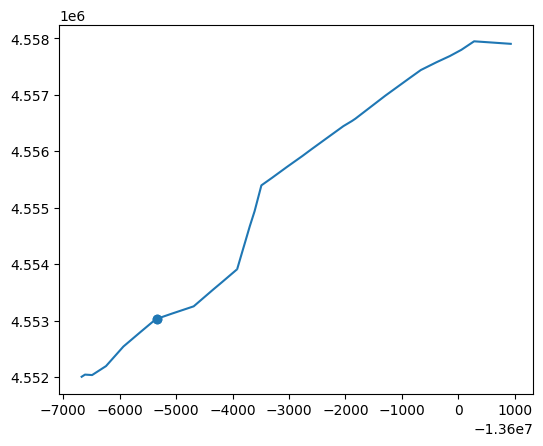

In [75]:
# for testing plotting the geometries
# put point, nearest_point, perpendicular_line, split_line in a dataframe
df = gpd.GeoDataFrame(columns=['geometry'])
df.loc[0, 'geometry'] = point
df.loc[1, 'geometry'] = nearest_point
df.loc[2, 'geometry'] = perpendicular_line
df.loc[3, 'geometry'] = split_line

df.plot()

[<POINT (-13606688.026 4551996.133)>, <POINT (-13605331.375 4553030.415)>, <POINT (-13603915.414 4553900.641)>]
[<POINT (-13606688.004 4551996.133)>, <POINT (-13605332.894 4553034.802)>, <POINT (-13603921.441 4553907.708)>]
[<LINESTRING (-13606688.026 4551996.133, -13606687.981 4551996.133)>, <LINESTRING (-13605331.375 4553030.415, -13605334.412 4553039.19)>, <LINESTRING (-13603915.414 4553900.641, -13603927.469 4553914.776)>]
MULTILINESTRING ((-13599052.633256342 4557902.102335841, -13599478.764267098 4557931.720966666, -13599720.516805222 4557948.130372991, -13599945.871982384 4557797.528520873, -13600150.454942564 4557687.119562891, -13600386.363207454 4557577.501205938, -13600664.127600923 4557439.338048369, -13600870.85902727 4557291.295041804, -13601294.017807622 4556984.558671143, -13601823.765000373 4556577.244801575, -13601884.84600497 4556536.184456926, -13602035.583727498 4556445.860726663, -13602322.776881807 4556238.167048183, -13602608.355903484 4556030.900363346, -136027

<Axes: >

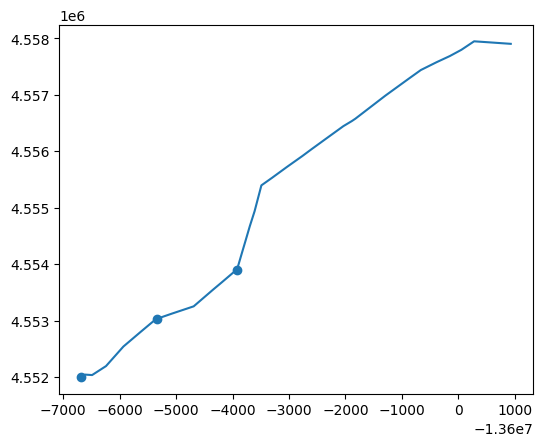

In [78]:
test_points = [
    multi_points[0],
    multi_points[1],
    multi_points[2],
]


# finda all the nearest points on the line to the points that intersect with the line
nearest_points_list = [nearest_points(line_geom, point)[0] for point in test_points]

reflected_point_list = [Point([2 * nearest_point.x - point.x, 2 * nearest_point.y - point.y]) for point, nearest_point in zip(test_points, nearest_points_list)]

# create perpendicular lines from the points that intersect with the line to the nearest points on the line
# perpendicular_lines = [LineString([point, nearest_point]) for point, nearest_point in zip(test_points, nearest_points_list)]
perpendicular_lines = [LineString([point, reflected_point]) for point, reflected_point in zip(test_points, reflected_point_list)]

# split_line = line_geom.difference(MultiLineString(perpendicular_lines))
# split_line = line_geom.difference(MultiPoint(nearest_points_list))

print(test_points)
print(nearest_points_list)
print(perpendicular_lines)
print(line_geom)
print(split_line)

df1 = gpd.GeoDataFrame(columns=['geometry'])
df1.loc[0, 'geometry'] = line_geom
df1.loc[1, 'geometry'] = MultiLineString(perpendicular_lines)
df1.loc[2, 'geometry'] = MultiPoint(test_points)

df1.plot()


/tmp/ipykernel_4152943/3832290922.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df2.explode().plot(color=['red', 'green', 'blue', 'black'])


<Axes: >

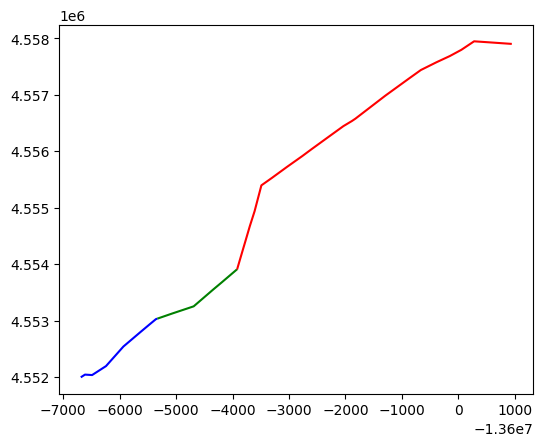

In [72]:
df2 = gpd.GeoDataFrame(columns=['geometry'])
df2.loc[0, 'geometry'] = split_line

# plot each line in the multilinestring a different color
df2.explode().plot(color=['red', 'green', 'blue', 'black'])


In [84]:
print(len(split_line.geoms))
for l in split_line.geoms:
    print(l)

3
LINESTRING (-13599052.633256342 4557902.102335841, -13599478.764267098 4557931.720966666, -13599720.516805222 4557948.130372991, -13599945.871982384 4557797.528520873, -13600150.454942564 4557687.119562891, -13600386.363207454 4557577.501205938, -13600664.127600923 4557439.338048369, -13600870.85902727 4557291.295041804, -13601294.017807622 4556984.558671143, -13601823.765000373 4556577.244801575, -13601884.84600497 4556536.184456926, -13602035.583727498 4556445.860726663, -13602322.776881807 4556238.167048183, -13602608.355903484 4556030.900363346, -13602763.902627956 4555915.295129995, -13603032.96183722 4555724.807232729, -13603302.577643901 4555528.00864003, -13603488.559117172 4555396.426411783, -13603608.695111638 4554939.255942421, -13603694.388855636 4554671.105033069, -13603769.930262087 4554413.431869092, -13603826.36924392 4554223.239233437, -13603918.02971264 4553910.618349472, -13603921.441405943 4553907.708497367)
LINESTRING (-13603921.441405943 4553907.708497367, -1360

In [81]:
df2.explode()

/tmp/ipykernel_4152943/108185714.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df2.explode()


geometry
0 0  LINESTRING (-13599052.633 4557902.102, -135994...
  1  LINESTRING (-13603921.441 4553907.708, -136041...
  2  LINESTRING (-13605332.894 4553034.802, -136053...

In [82]:
# subset df_l for geom type MultiLineString
df_l[df_l['geometry'].geom_type == 'MultiLineString']


,id,tags.power,Type,Country,Length,tags.cables,tags.voltage,tags.circuits,tags.frequency,geometry
5,5083780,line,Way,US,120709.508431,NaN,115000,NaN,NaN,"MULTILINESTRING ((-13381039.233 5620730.217, -..."
10,5126580,line,Way,US,48213.836681,3,115000,NaN,NaN,"MULTILINESTRING ((-13132567.851 5204307.244, -..."
11,5129796,line,Way,US,22867.860922,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-13035028.811 5425654.285, -..."
15,5144891,line,Way,US,69569.868005,NaN,115000,NaN,NaN,"MULTILINESTRING ((-13456428.955 5211864.117, -..."
31,5189892,line,Way,US,44892.137557,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-13173140.610 5550478.666, -..."
32,5192461,line,Way,US,2567.526832,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-13493074.897 5720240.844, -..."
68,5292746,line,Way,US,100269.413460,3,500000,NaN,60,"MULTILINESTRING ((-8598131.810 4772719.805, -8..."
163,5421054,line,Way,US,18745.533356,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-12178379.143 5660975.657, -..."
176,5426045,line,Way,US,6411.069534,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-12201042.378 5667525.874, -..."
227,5513555,line,Way,US,18110.382197,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-13658449.908 5707036.917, -..."


In [83]:
print(len(lines))
print(len(df_l))
print(len(df_l[df_l['geometry'].geom_type == 'MultiLineString']))
print(len(df_l.explode(index_parts=False)))


174222
174222
44
174269


In [93]:
def fix_overpassing_lines(lines, buses, distance_crs, tol=1):
    """
    Function to snap buses to lines that are within a certain tolerance.

    Parameters
    ----------
    lines : GeoDataFrame
        GeoDataFrame containing the lines
    buses : GeoDataFrame
        GeoDataFrame containing the buses
    distance_crs : str
        Coordinate reference system to use for distance calculations
    tol : float
        Tolerance in meters to snap the buses to the lines

    Returns
    -------
    lines : GeoDataFrame
        GeoDataFrame containing the lines
    """

    df_l = lines.copy()  # can use lines directly without copying
    # drop all columns except id and geometry for buses
    df_p = buses.copy()

    line_id_str = "id"
    bus_id_str = "id"

    # change crs to distance based
    df_l = df_l.to_crs(distance_crs)
    df_p = df_p.to_crs(distance_crs)

    # set index to bus_id
    df_p.set_index(bus_id_str, inplace=True)

    # Buffer points to create areas for spatial join
    buffer_df = df_p.buffer(tol).to_frame()

    # Spatial join to find lines intersecting point buffers
    joined = gpd.sjoin(df_l, buffer_df, how="inner", op="intersects")

    # group lines by their ids
    group_lines = joined.groupby(line_id_str)

    # iterate over the groups, TODO: change to apply
    for i, group in group_lines:
        line_id = i  # pick the line id that represents the group
        line_geom = df_l[df_l[line_id_str] == line_id]["geometry"].iloc[0]

        # number of points that intersect with the line
        num_points = len(group)

        # get the indices of the points that intersect with the line
        points_indexes = group["index_right"].tolist()

        # get the geometries of the points that intersect with the line
        multi_points = df_p.loc[points_indexes, "geometry"].tolist()

        # find all the nearest points on the line to the points that intersect with the line
        nearest_points_list = [
            nearest_points(line_geom, point)[0] for point in multi_points
        ]

        # reflect the points in the line to create a bisector
        reflected_points_list = [Point([2 * nearest_point.x - point.x, 2 * nearest_point.y - point.y]) for point, nearest_point in zip(multi_points, nearest_points_list)]

        # create perpendicular lines from the points that intersect with the line to the nearest points on the line
        perpendicular_lines = [LineString([point, reflected_point]) for point, reflected_point in zip(multi_points, reflected_points_list)]

        # split the line geom with the perpendicular lines using difference
        split_line = line_geom.difference(MultiLineString(perpendicular_lines))

        # replace the line with the split line in lines df
        df_l.loc[df_l[line_id_str] == line_id, "geometry"] = split_line

        
    # explode the multilinestrings (not recommended, but included for completion)
    # exploding the df should be done at the last step
    # if an operation requires separate lines, it should be done using df.explode().apply(your_function)
    # which is a lot more memory efficient
    # df_l = df_l.explode(index_parts=False)  # (recommended)
    df_l = df_l.explode(ignore_index=True)

    # update line endings (included for completion, the scope of the function should be limited to fixing overpassing lines)
    # commented out due to errors in the bus conversion function
    # df_l = line_endings_to_bus_conversion(df_l)

    # update length
    df_l["length"] = df_l.to_crs(distance_crs).geometry.length

    # return to original crs
    df_l = df_l.to_crs(lines.crs)

    # remove lines that are rings (included for completion), TODO: this should be a separate function
    df_l = df_l[~df_l.geometry.is_ring].reset_index()

    # buses should not be returned as they are not changed, but included for completion
    return df_l, buses

In [90]:
lines_fast, _ = fix_overpassing_lines(lines.copy(), buses.copy(), distance_crs = 'EPSG:3857', tol=tol)
lines_fast

/home/matin/PRs/pypsa-africa/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,index,id,tags.power,Type,Country,Length,tags.cables,tags.voltage,tags.circuits,tags.frequency,geometry,length
0,0,5039311,line,Way,US,36409.674450,NaN,NaN,NaN,NaN,"LINESTRING (-121.92167 45.64014, -121.91812 45...",36409.674450
1,1,5039699,line,Way,US,5209.154031,NaN,115000,NaN,NaN,"LINESTRING (-121.57024 45.69121, -121.56003 45...",5209.154031
2,2,5040320,line,Way,US,6562.489379,NaN,NaN,NaN,NaN,"LINESTRING (-121.62698 45.69699, -121.61989 45...",6562.489379
3,3,5047240,line,Way,US,5946.825602,NaN,NaN,NaN,NaN,"LINESTRING (-76.86410 40.40408, -76.84822 40.4...",5946.825602
4,4,5083770,line,Way,US,54941.618766,3,115000,1,NaN,"LINESTRING (-120.68702 45.51555, -120.68733 45...",54941.618766
...,...,...,...,...,...,...,...,...,...,...,...,...
184816,185214,1150267302,line,Way,US,214.567151,3,115000,NaN,NaN,"LINESTRING (-73.52146 41.06070, -73.52112 41.0...",214.567151
184817,185215,1150267303,line,Way,US,95.193636,9,115000,NaN,NaN,"LINESTRING (-73.53741 41.04800, -73.53692 41.0...",95.193636
184818,185216,1150267304,line,Way,US,246.215247,3,115000,NaN,NaN,"LINESTRING (-73.53692 41.04853, -73.53749 41.0...",246.215247
184819,185217,1150267305,line,Way,US,3124.827285,3,115000,NaN,NaN,"LINESTRING (-73.53772 41.04803, -73.53801 41.0...",3124.827285


In [94]:
print(len(lines))
print(len(lines_fast))
print(len(lines_fast[lines_fast['geometry'].geom_type == 'MultiLineString']))

174222
184821
0


In [ ]:
for i, row in lines_fast.iterrows():
    print(i, lines_fast.geometry.loc[i])
    lines_fast.geometry.loc[i].boundary.geoms[0]